# Gene Regulation in Immune Cells - ab and gd T Cells

## 0. Import of Packages and Data

In [23]:
# --- Grundlegende Pakete ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Farben und Visualisierung ---
from matplotlib.colors import ListedColormap, LogNorm
import matplotlib.patches as mpatches

# --- Statistik und Metriken ---
import scipy.stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity

# --- Clustering & Dim-Red ---
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn.manifold as sklm
import umap

# --- Single-cell Analysis ---
import scanpy as sc
import leidenalg

# --- Sonstiges ---
import importlib

import functions
importlib.reload(functions)
functions.set_user('Pia')

In [57]:
data = functions.call_data_clean(p_threshold=None)
ATAC = data['ATAC_seq']
RNA = data['RNA_seq']
QC = data['QC_metrics']
ATAC_scores = data['norm_scores']
exons = data['exons']
ATACtest = data['test1']
ATAC_dis_path = '/Users/piakentschke/Documents/Uni/Data Analysis/ATAC_dis_annotated.csv'
ATAC_dis = pd.read_csv(ATAC_dis_path)

Clean-up performed in functions.py (only 5 peaks with infinite log_p_values were excluded and a p-threshold of 1.3 can be applied)

## I. Descriptive Data Analysis
---

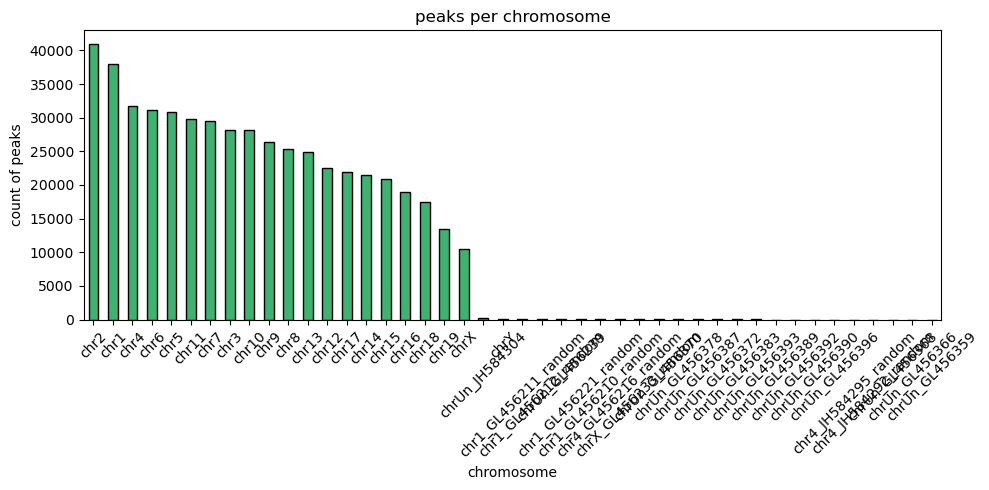

In [58]:
# counts of ATAC peaks per chromosome
chrom_counts = ATAC["chrom"].value_counts().sort_values(ascending=False)
peak_list = list(zip(chrom_counts.index, chrom_counts.values))

plt.figure(figsize=(10,5))
chrom_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title("peaks per chromosome")
plt.xlabel("chromosome")
plt.ylabel("count of peaks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

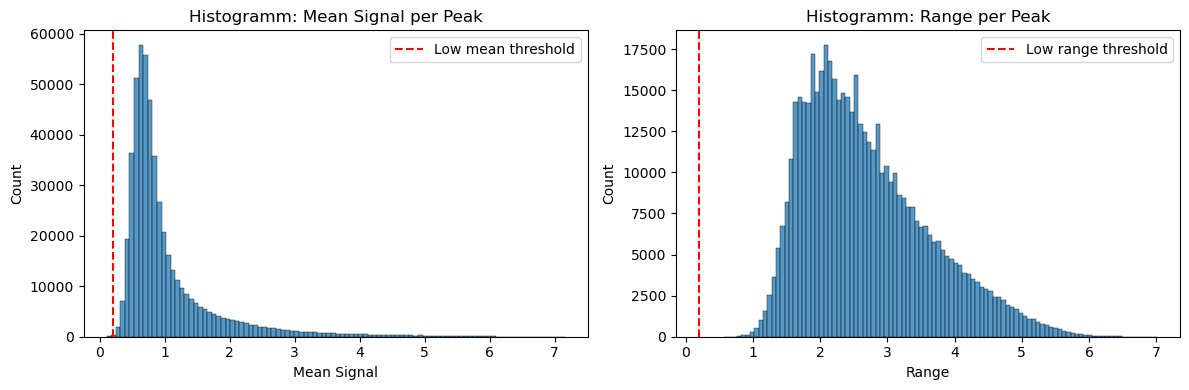

Peaks with low signal (mean < 0.2 und range < 0.2): 0 of 512590 peaks (0.00%)


In [59]:
# mean and 
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(ATAC_dis['mean'], bins=100)
plt.axvline(0.2, color='red', linestyle='--', label='Low mean threshold')
plt.title("Histogramm: Mean Signal per Peak")
plt.xlabel("Mean Signal")
plt.legend()

plt.subplot(1,2,2)
sns.histplot(ATAC_dis['range'], bins=100)
plt.axvline(0.2, color='red', linestyle='--', label='Low range threshold')
plt.title("Histogramm: Range per Peak")
plt.xlabel("Range")
plt.legend()
plt.tight_layout()
plt.show()

low_signal = ATAC_dis[(ATAC_dis['mean'] < 0.2) & (ATAC_dis['range'] < 0.2)]
n_low = len(low_signal)
total = len(ATAC_dis)
print(f"Peaks with low signal (mean < 0.2 und range < 0.2): {n_low} of {total} peaks ({n_low/total:.2%})")

No detectably low signal from ATAC-seq dataset.
Additional threshold for -log10pVal can be applied (e.g. >=1.3)

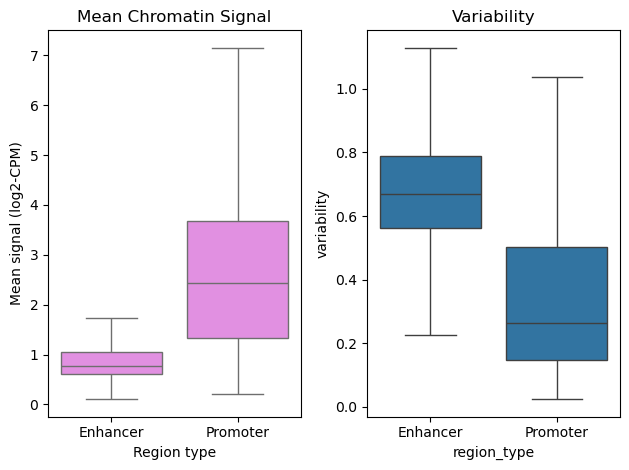

In [60]:
plt.subplot(1,2,1)
sns.boxplot(x='region_type', y='mean', data=ATAC_dis, color='violet', showfliers=False)
plt.title("Mean Chromatin Signal")
plt.xlabel("Region type")
plt.ylabel("Mean signal (log2-CPM)")

plt.subplot(1,2,2)
sns.boxplot(x='region_type', y='variability', data=ATAC_dis, showfliers=False)
plt.title("Variability")

plt.tight_layout()
plt.show()

If promoters are defined as everything with <300bp distance to a gene, a significant difference between enhancer/promoter can be seen in terms of mean peak signal and standard deviation.
Enhancers have a lower, more variable signal than promoters. To varify, we perform a t-test.

In [61]:
# mean-testing
prom = ATAC_dis[ATAC_dis['region_type']=='Promoter']['mean']
enh = ATAC_dis[ATAC_dis['region_type']=='Enhancer']['mean']
# t-Test
t_stat, p_val = scipy.stats.ttest_ind(prom, enh, equal_var=False)
print(f"T-test promoter vs enhancer mean: t={t_stat:.2f}, p={p_val:.1e}")
if p_val < 1e-300:
    print("p < 1e-300 (close to 0, highly significant)")

#variability testing
prom2 = ATAC_dis[ATAC_dis['region_type']=='Promoter']['variability']
enh2 = ATAC_dis[ATAC_dis['region_type']=='Enhancer']['variability']
# t-Test
t_stat, p_val = scipy.stats.ttest_ind(prom2, enh2, equal_var=False)
print(f"T-test promoter vs enhancer mean: t={t_stat:.2f}, p={p_val:.1e}")
if p_val < 1e-300:
    print("p < 1e-300 (close to 0, highly significant)")

T-test promoter vs enhancer mean: t=192.57, p=0.0e+00
p < 1e-300 (close to 0, highly significant)
T-test promoter vs enhancer mean: t=-236.74, p=0.0e+00
p < 1e-300 (close to 0, highly significant)


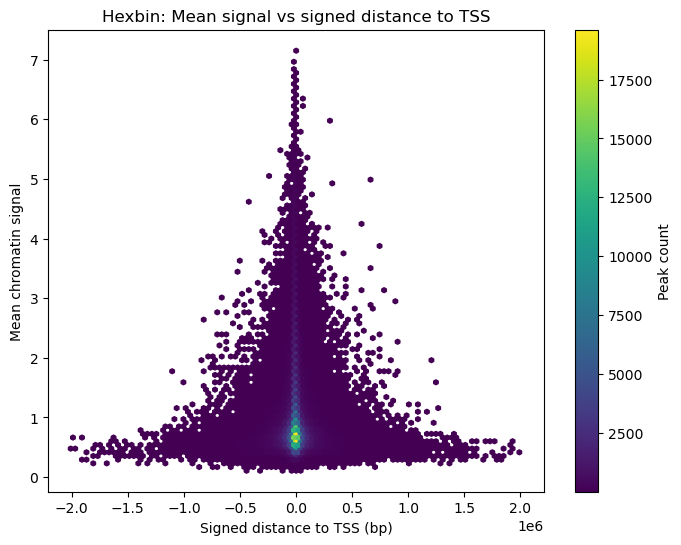

In [62]:
plt.figure(figsize=(8,6))
plt.hexbin(ATAC_dis['distance_to_TSS'], ATAC_dis['mean'], gridsize=100, cmap='viridis', mincnt=1)
plt.xlabel("Signed distance to TSS (bp)")
plt.ylabel("Mean chromatin signal")
plt.title("Hexbin: Mean signal vs signed distance to TSS")
plt.colorbar(label='Peak count')
plt.show()

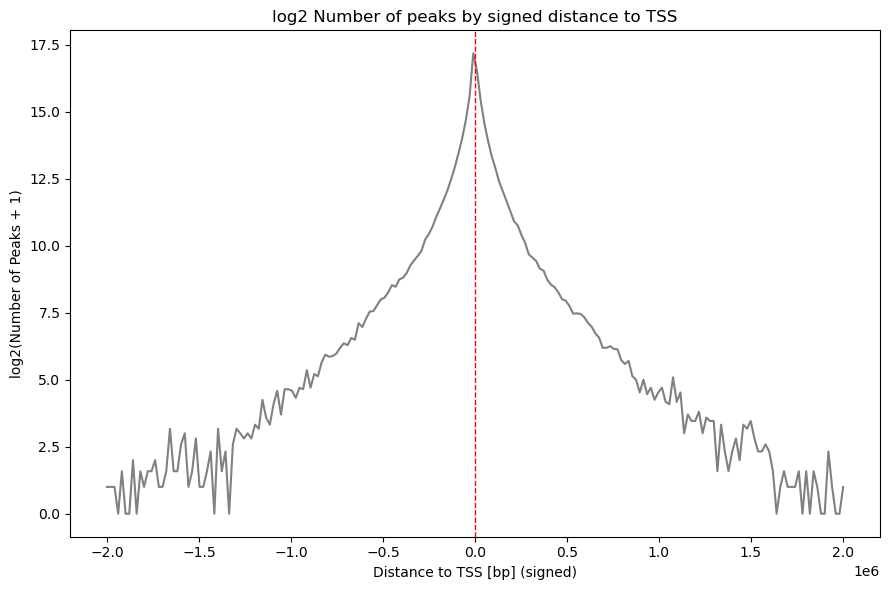

In [63]:
hist, bins = np.histogram(ATAC_dis['distance_to_TSS'].dropna(), bins=200)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(9,6))
plt.plot(bin_centers, np.log2(hist + 1), color='gray')  # +1 für log(0) avoidance
plt.axvline(0, color='red', linestyle='--', lw=1)
plt.xlabel('Distance to TSS [bp] (signed)')
plt.ylabel('log2(Number of Peaks + 1)')
plt.title('log2 Number of peaks by signed distance to TSS')
plt.tight_layout()
plt.show()

Open chromatin regions mostly lie at TSS/very close to TSS. 

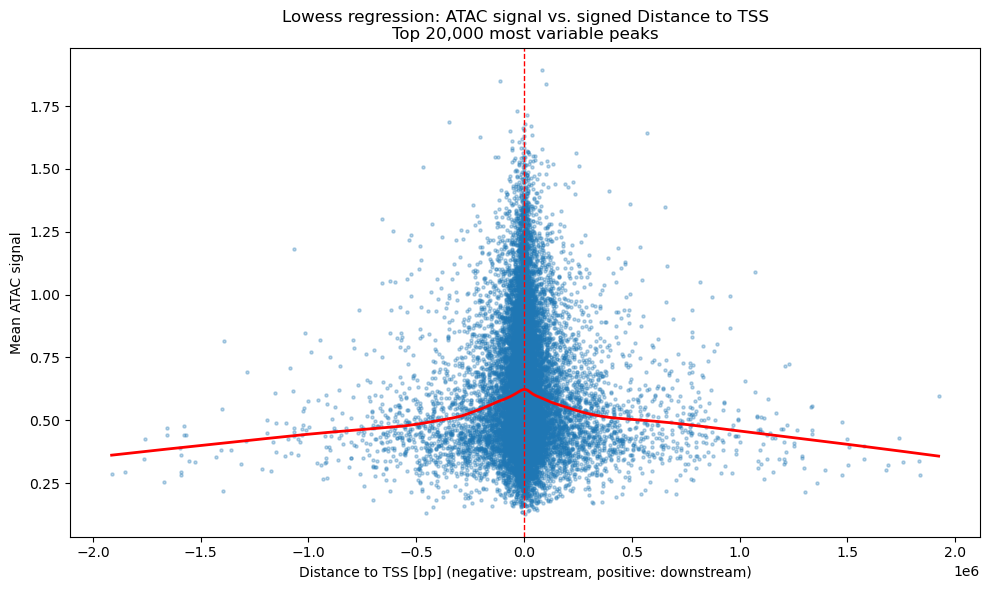

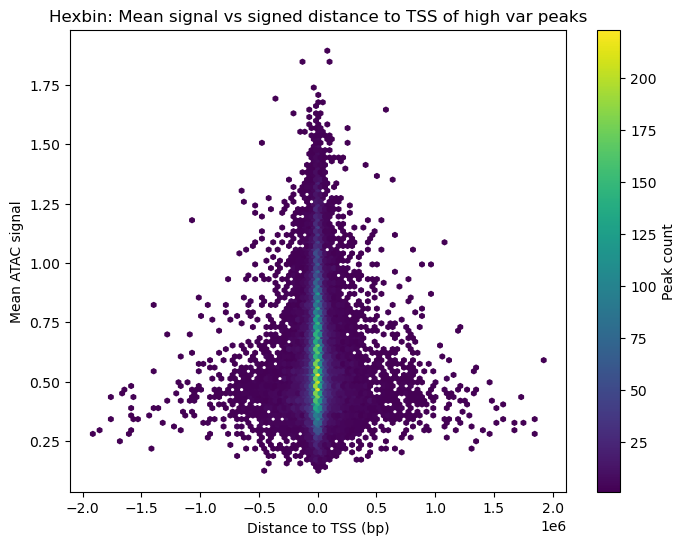

In [64]:
top_n = 20000
peaks_topvar = ATAC_dis.sort_values('variability', ascending=False).head(top_n)

# 2. Nur valide Werte (kein NaN, keine 0-Distanz)
mask_valid = peaks_topvar['distance_to_TSS'].notna() & (peaks_topvar['distance_to_TSS'] != 0)
x = peaks_topvar.loc[mask_valid, 'distance_to_TSS']
y = peaks_topvar.loc[mask_valid, 'mean']

# 3. Plot: Scatter + Lowess-Regression
plt.figure(figsize=(10, 6))
sns.regplot(
    x=x, y=y,
    scatter_kws={'s':5, 'alpha':0.3},
    line_kws={'color':'red', 'lw':2},
    lowess=True
)
plt.xlabel('Distance to TSS [bp] (negative: upstream, positive: downstream)')
plt.ylabel('Mean ATAC signal')
plt.title('Lowess regression: ATAC signal vs. signed Distance to TSS\nTop 20,000 most variable peaks')
plt.axvline(0, color='red', linestyle='--', lw=1)
plt.tight_layout()
plt.show()

#hexplot 

plt.figure(figsize=(8,6))
plt.hexbin(
    x=x, y=y,
    gridsize=100, cmap='viridis', mincnt=1)
plt.xlabel("Distance to TSS (bp)")
plt.ylabel("Mean ATAC signal")
plt.title("Hexbin: Mean signal vs signed distance to TSS of high var peaks")
plt.colorbar(label='Peak count')
plt.show()


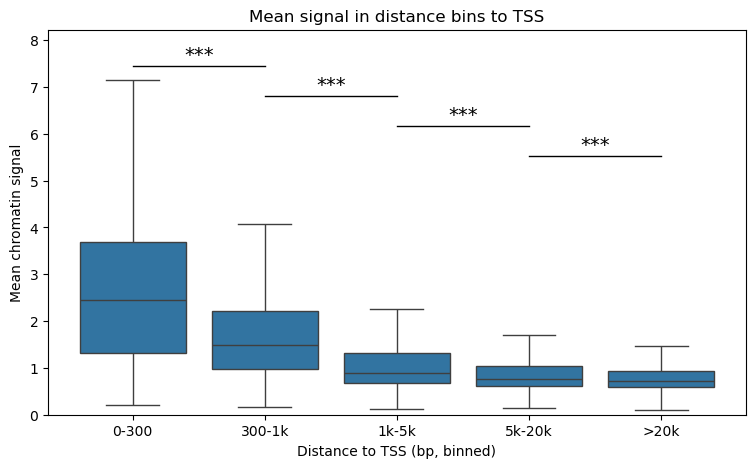

In [65]:
plt.figure(figsize=(9,5))
ax = sns.boxplot(x='TSS_bin', y='mean', data=ATAC_dis, showfliers=False, order=labels)
plt.title("Mean signal in distance bins to TSS")
plt.xlabel("Distance to TSS (bp, binned)")
plt.ylabel("Mean chromatin signal")

# Berechnung für die Linien wie gehabt
y_max = ATAC_dis['mean'].max()
y_start = y_max + 0.3
y_offset = y_max * 0.09

for i, p in enumerate(p_values):
    x1, x2 = i, i+1
    y = y_start - i * y_offset
    marker = functions.significance_marker(p)
    plt.plot([x1, x2], [y, y], lw=1, c='k')
    plt.text((x1+x2)*.5, y + y_offset*0.05, marker, ha='center', va='bottom', color='k', fontsize=14)

# Skala anpassen
plt.ylim(0, y_start + y_offset * 1.2)
plt.show()

OCRs closer to TSS have higher ATAC signals compared to those further away (as in Promoter vs Enhancer Mean Signal)

## II. Exploratory Analysis
---

### II.1 Effects of logP Value and Variability filtering

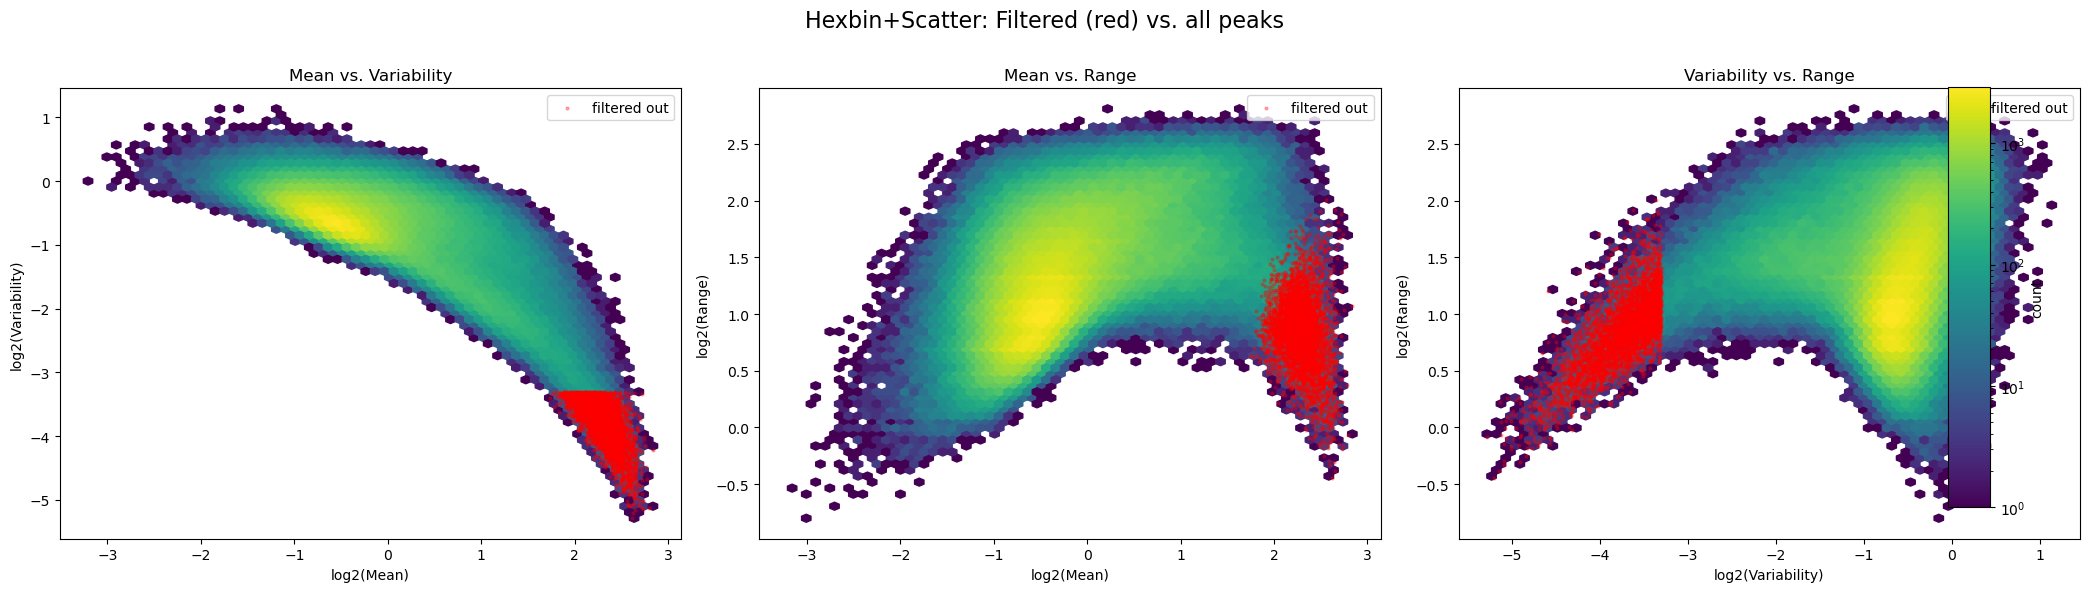

In [66]:
mean_thr = 0.05
var_thr = 0.1
range_thr = 0.1

# 2. Markiere Peaks, die zu filtern wären
ATAC_dis['low_mean'] = ATAC_dis['mean'] < mean_thr
ATAC_dis['low_variability'] = ATAC_dis['variability'] < var_thr
ATAC_dis['low_range'] = ATAC_dis['range'] < range_thr

# Filter-Maske: mind. eines der Kriterien erfüllt
filtered_mask = ATAC_dis['low_mean'] | ATAC_dis['low_variability'] | ATAC_dis['low_range']
filtered_mask_pval = ATAC_dis[ATAC_dis['_-log10_bestPvalue'] >= 1.3]

# 3. Berechne log2 für Statistiken
mean_log2 = np.log2(ATAC_dis['mean'] + 1e-3)
variability_log2 = np.log2(ATAC_dis['variability'] + 1e-3)
range_log2 = np.log2(ATAC_dis['range'] + 1e-3)

# 4. Plotte 3 Subplots (Hexbin+Scatter)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

plots = [
    (mean_log2, variability_log2, "log2(Mean)", "log2(Variability)", "Mean vs. Variability"),
    (mean_log2, range_log2, "log2(Mean)", "log2(Range)", "Mean vs. Range"),
    (variability_log2, range_log2, "log2(Variability)", "log2(Range)", "Variability vs. Range"),
]

for ax, (x, y, xlabel, ylabel, title) in zip(axes, plots):
    # Hexbin für alle Peaks
    hb = ax.hexbin(x, y, gridsize=60, cmap='viridis', norm=LogNorm())
    # Scatter für gefilterte Peaks
    ax.scatter(
        x[filtered_mask], y[filtered_mask],
        color='red', s=4, alpha=0.3, label="filtered out"
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

fig.suptitle("Hexbin+Scatter: Filtered (red) vs. all peaks", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
# Gemeinsame Colorbar für alle Subplots
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='count')

plt.show()

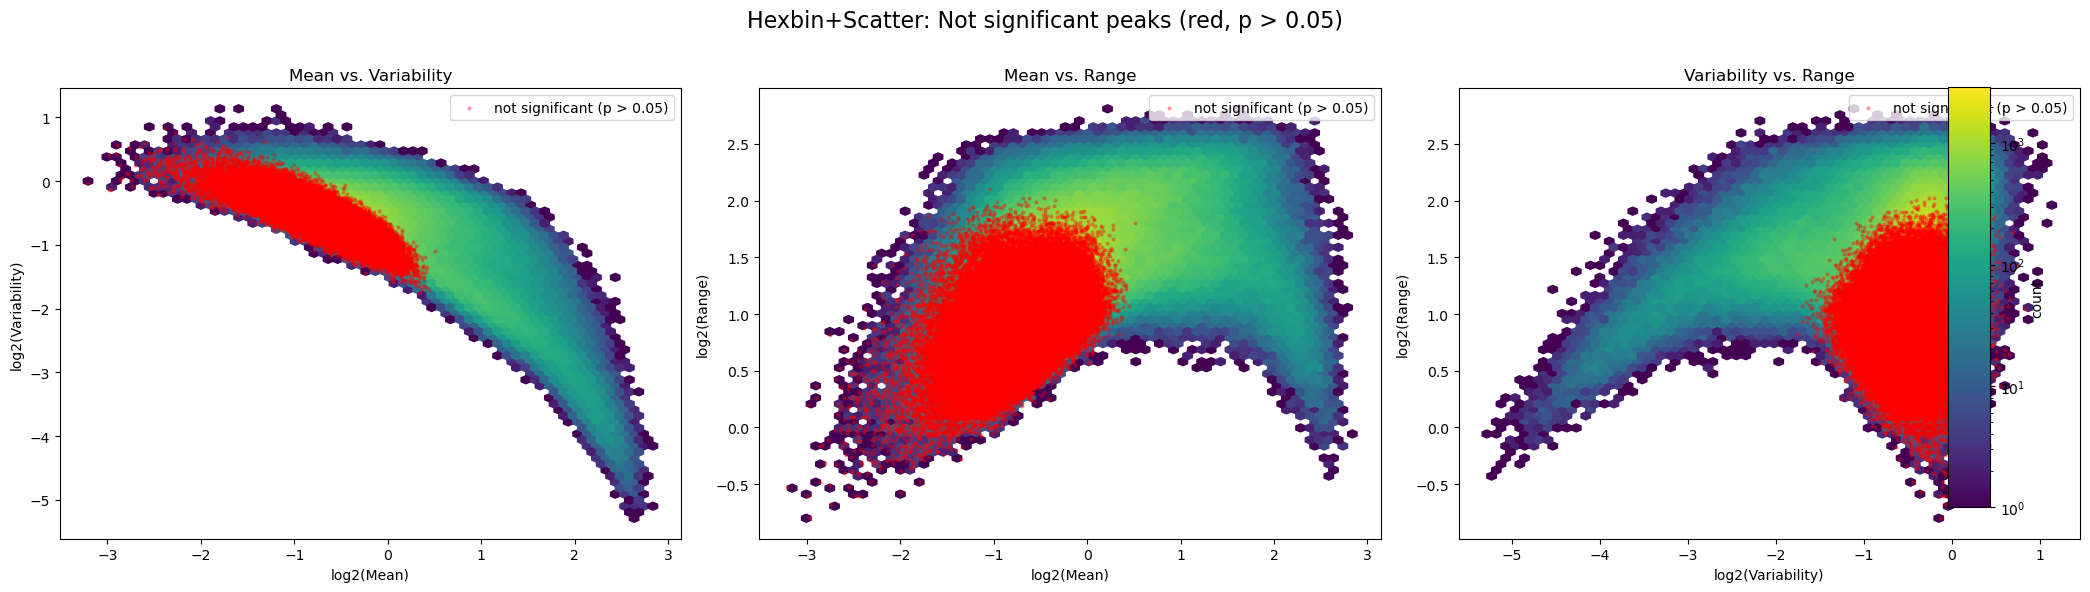

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

mean_thr = 0.05
var_thr = 0.1
range_thr = 0.1

# 2. Markiere Peaks, die zu filtern wären
ATAC_dis['low_mean'] = ATAC_dis['mean'] < mean_thr
ATAC_dis['low_variability'] = ATAC_dis['variability'] < var_thr
ATAC_dis['low_range'] = ATAC_dis['range'] < range_thr

# Filter-Maske: mind. eines der Kriterien erfüllt
filtered_mask = ATAC_dis['low_mean'] | ATAC_dis['low_variability'] | ATAC_dis['low_range']
filtered_mask_pval = ATAC_dis['_-log10_bestPvalue'] < 1.3

plots = [
    (mean_log2, variability_log2, "log2(Mean)", "log2(Variability)", "Mean vs. Variability"),
    (mean_log2, range_log2, "log2(Mean)", "log2(Range)", "Mean vs. Range"),
    (variability_log2, range_log2, "log2(Variability)", "log2(Range)", "Variability vs. Range"),
]

for ax, (x, y, xlabel, ylabel, title) in zip(axes, plots):
    hb = ax.hexbin(x, y, gridsize=60, cmap='viridis', norm=LogNorm())
    # Scatter nur für nicht-signifikante Peaks (p > 0.05)
    ax.scatter(
        x[filtered_mask_pval], y[filtered_mask_pval],
        color='red', s=4, alpha=0.3, label="not significant (p > 0.05)"
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

fig.suptitle("Hexbin+Scatter: Not significant peaks (red, p > 0.05)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='count')

plt.show()

### I.2 RNA-seq Data Set